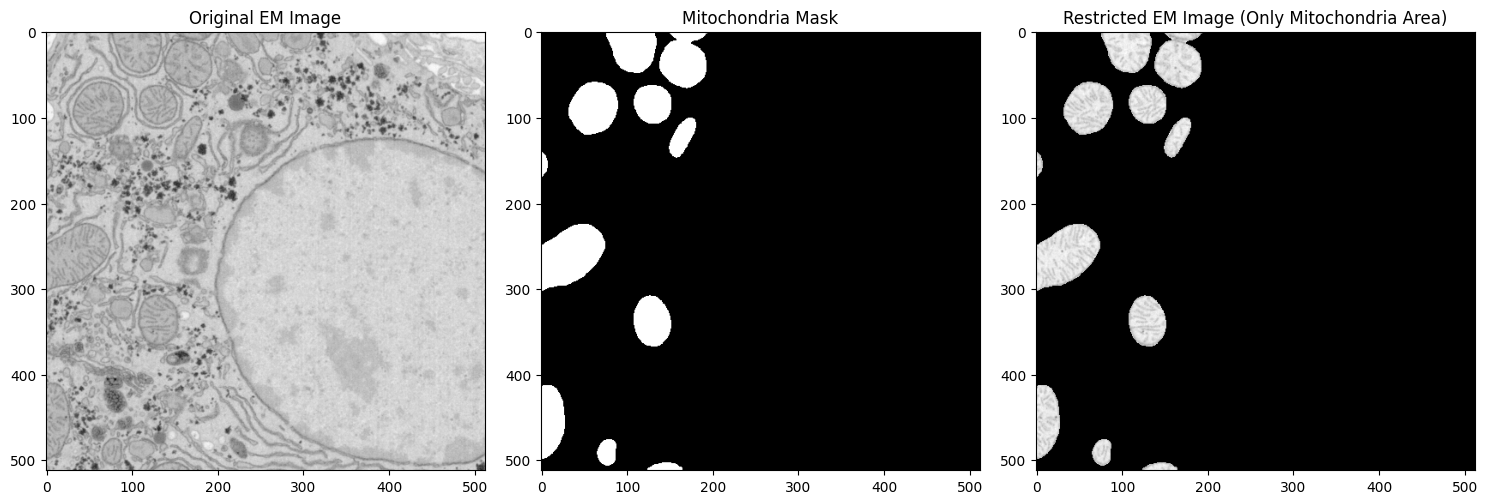

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def load_images_from_folder(folder_path, resize_shape=(512, 512), normalize=False):
    image_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files] 
    images = [cv2.resize(img, resize_shape) for img in images] 
    if normalize:
        images = np.array(images) / 255.0  
    else:
        images = np.array(images)
    return images

def load_binary_masks_from_folder(folder_path, resize_shape=(512, 512)):
    mask_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    masks = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in mask_files]  
    masks = [cv2.resize(mask, resize_shape) for mask in masks]  
    masks = np.array(masks) / 255.0  
    return masks

images_folder = 'dataset/images'  
mitos_folder = 'dataset/mitos' 
cristae_folder = 'dataset/cristae'  

x_val = load_images_from_folder(images_folder, normalize=True)  
mito_pred_bin = load_binary_masks_from_folder(mitos_folder)  
y_cristae_val = load_binary_masks_from_folder(cristae_folder)  

x_val = np.expand_dims(x_val, axis=-1)
mito_pred_bin = np.expand_dims(mito_pred_bin, axis=-1)
y_cristae_val = np.expand_dims(y_cristae_val, axis=-1)

restricted_em_images = x_val * mito_pred_bin  

def plot_image_comparison(original_image, mito_mask, restricted_image):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original EM Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mito_mask.squeeze(), cmap='gray')
    plt.title('Mitochondria Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(restricted_image.squeeze(), cmap='gray')
    plt.title('Restricted EM Image (Only Mitochondria Area)')
    
    plt.tight_layout()
    plt.show()

plot_image_comparison(x_val[0], mito_pred_bin[0], restricted_em_images[0])


In [2]:
def extract_lbp_features(image, radius=1, n_points=8):
    image_uint8 = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(image_uint8, n_points, radius, method="uniform")
    return lbp

def extract_features_in_mito_region(em_image, mito_mask):
    restricted_image = em_image * mito_mask  
   
    lbp_features = extract_lbp_features(restricted_image)
    
    intensity_features = restricted_image.flatten()
    lbp_features = lbp_features.flatten()
    
    combined_features = np.column_stack((intensity_features, lbp_features))
    return combined_features

features = []
labels = []  

for i in range(len(x_val)):
    em_image = x_val[i].squeeze()  
    mito_mask = mito_pred_bin[i].squeeze() 
    cristae_mask = y_cristae_val[i].squeeze()  
    
    feature_vector = extract_features_in_mito_region(em_image, mito_mask)
    
    cristae_labels = cristae_mask.flatten()
    
    features.append(feature_vector)
    labels.append(cristae_labels)

features = np.vstack(features)
labels = np.hstack(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=7)

clf = RandomForestClassifier(n_estimators=25, random_state=7, warm_start=True)  

for i in range(1, clf.n_estimators + 1):
    clf.set_params(n_estimators=i)  
    clf.fit(X_train, y_train)      
    print(f'Training with {i} estimators completed.')

y_pred = clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Training with 1 estimators completed.
Training with 2 estimators completed.
Training with 3 estimators completed.
Training with 4 estimators completed.
Training with 5 estimators completed.
Training with 6 estimators completed.
Training with 7 estimators completed.
Training with 8 estimators completed.
Training with 9 estimators completed.
Training with 10 estimators completed.
Training with 11 estimators completed.
Training with 12 estimators completed.
Training with 13 estimators completed.
Training with 14 estimators completed.
Training with 15 estimators completed.
Training with 16 estimators completed.
Training with 17 estimators completed.
Training with 18 estimators completed.
Training with 19 estimators completed.
Training with 20 estimators completed.
Training with 21 estimators completed.
Training with 22 estimators completed.
Training with 23 estimators completed.
Training with 24 estimators completed.
Training with 25 estimators completed.
Accuracy:  0.9926105499267578
    

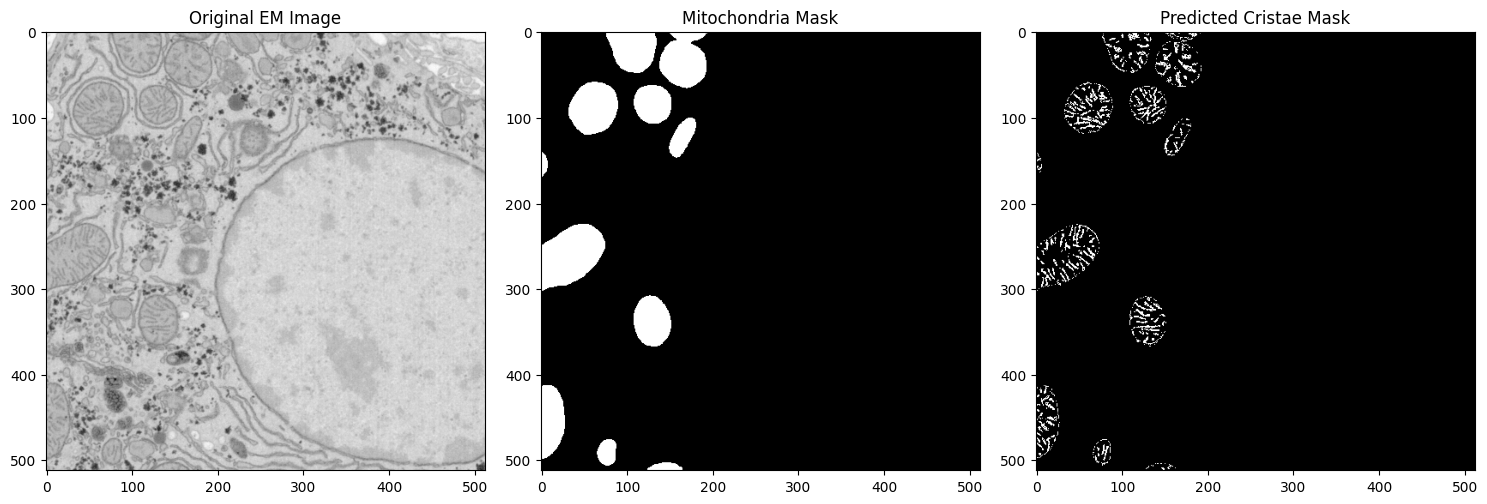

In [3]:
def predict_cristae_in_mito_region(em_image, mito_mask, clf):
    feature_vector = extract_features_in_mito_region(em_image, mito_mask)
    cristae_pred = clf.predict(feature_vector).reshape(512, 512)
    return cristae_pred

cristae_predictions = []

for i in range(len(x_val)):
    em_image = x_val[i].squeeze()
    mito_mask = mito_pred_bin[i].squeeze()
    
    cristae_pred = predict_cristae_in_mito_region(em_image, mito_mask, clf)
    cristae_predictions.append(cristae_pred)

def plot_results(original_image, mito_mask, cristae_pred):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original EM Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mito_mask, cmap='gray')
    plt.title('Mitochondria Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(cristae_pred, cmap='gray')
    plt.title('Predicted Cristae Mask')

    plt.tight_layout()
    plt.show()

plot_results(x_val[-1].squeeze(), mito_pred_bin[-1].squeeze(), cristae_predictions[-1])


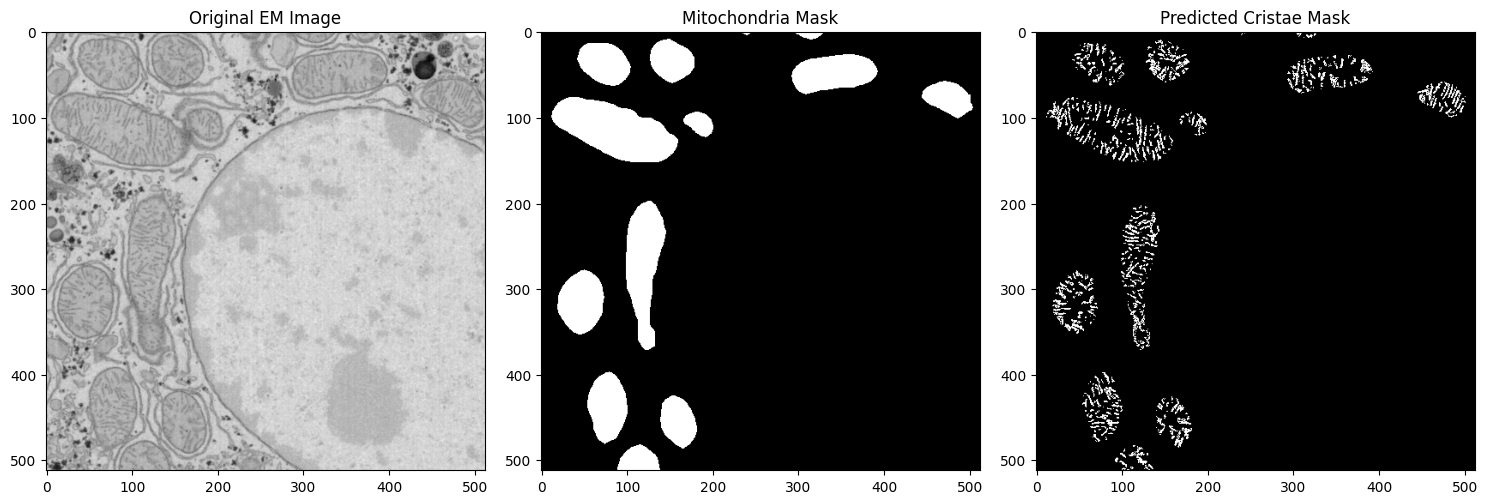

In [11]:
def erode_mito_mask(mito_mask, erosion_size=3):
    
    kernel = np.ones((erosion_size, erosion_size), np.uint8)
    
    eroded_mito_mask = cv2.erode(mito_mask, kernel, iterations=1)
    
    return eroded_mito_mask

cristae_predictions = []

for i in range(len(x_val)):
    em_image = x_val[i].squeeze()
    mito_mask = mito_pred_bin[i].squeeze()
   
    eroded_mito_mask = erode_mito_mask(mito_mask, erosion_size=9)
    
    cristae_pred = predict_cristae_in_mito_region(em_image, eroded_mito_mask, clf)
   
    cristae_predictions.append(cristae_pred)

plot_results(x_val[-1].squeeze(), eroded_mito_mask, cristae_predictions[-1])


In [12]:
from skimage.filters import sobel

def extract_sobel_edges(image):
    edges = sobel(image)  
    return edges

def extract_features_in_mito_region(em_image, mito_mask):
    restricted_image = em_image * mito_mask  
   
    lbp_features = extract_lbp_features(restricted_image)
   
    edge_features = extract_sobel_edges(restricted_image)
   
    intensity_features = restricted_image.flatten()
    lbp_features = lbp_features.flatten()
    edge_features = edge_features.flatten()
    
    combined_features = np.column_stack((intensity_features, lbp_features, edge_features))
    return combined_features

features = []
labels = []  

for i in range(len(x_val)):
    em_image = x_val[i].squeeze()  
    mito_mask = mito_pred_bin[i].squeeze() 
    cristae_mask = y_cristae_val[i].squeeze()  
    
    feature_vector = extract_features_in_mito_region(em_image, mito_mask)
    
    cristae_labels = cristae_mask.flatten()
    
    features.append(feature_vector)
    labels.append(cristae_labels)

features = np.vstack(features)
labels = np.hstack(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=7)

clf2 = RandomForestClassifier(n_estimators=25, random_state=7, warm_start=True)  

for i in range(1, clf2.n_estimators + 1):
    clf2.set_params(n_estimators=i)  
    clf2.fit(X_train, y_train)      
    print(f'Training with {i} estimators completed.')

y_pred = clf2.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training with 1 estimators completed.
Training with 2 estimators completed.
Training with 3 estimators completed.
Training with 4 estimators completed.
Training with 5 estimators completed.
Training with 6 estimators completed.
Training with 7 estimators completed.
Training with 8 estimators completed.
Training with 9 estimators completed.
Training with 10 estimators completed.
Training with 11 estimators completed.
Training with 12 estimators completed.
Training with 13 estimators completed.
Training with 14 estimators completed.
Training with 15 estimators completed.
Training with 16 estimators completed.
Training with 17 estimators completed.
Training with 18 estimators completed.
Training with 19 estimators completed.
Training with 20 estimators completed.
Training with 21 estimators completed.
Training with 22 estimators completed.
Training with 23 estimators completed.
Training with 24 estimators completed.
Training with 25 estimators completed.
Accuracy:  0.9943897247314453
    

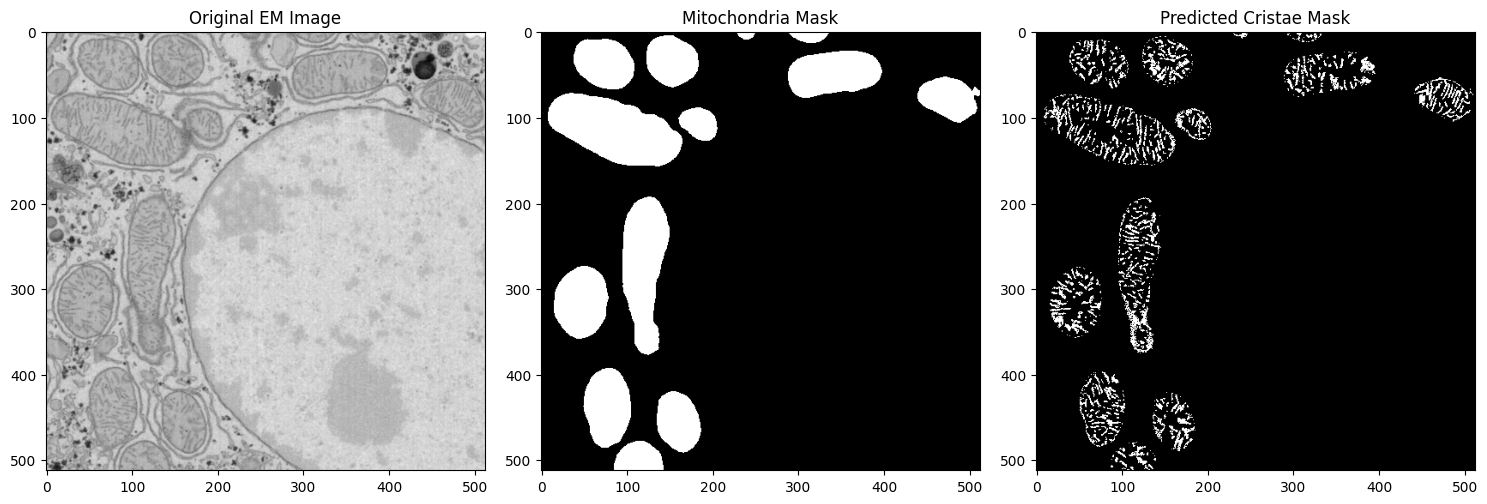

In [13]:
cristae_predictions = []

for i in range(len(x_val)):
    em_image = x_val[i].squeeze()
    mito_mask = mito_pred_bin[i].squeeze()
    
    cristae_pred = predict_cristae_in_mito_region(em_image, mito_mask, clf2)
    cristae_predictions.append(cristae_pred)

plot_results(x_val[-1].squeeze(), mito_pred_bin[-1].squeeze(), cristae_predictions[-1])